<a href="https://colab.research.google.com/github/IonutVladeanu/Personal-Projects/blob/main/Binary_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [22]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y  = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

In [23]:
print(len(X), len(y))

1000 1000


In [24]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [25]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


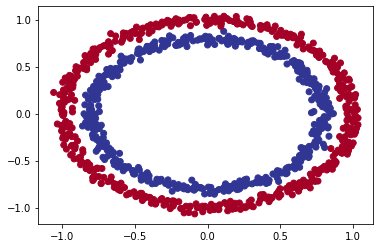

In [26]:
# Visualizing the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

## 2. Check input and outputs


In [27]:
print(X.shape, y.shape)

(1000, 2) (1000,)


In [28]:
print(X)

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 ...
 [-0.13690036 -0.81001183]
 [ 0.67036156 -0.76750154]
 [ 0.28105665  0.96382443]]


In [29]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 3. Turn data into tensors and create train and test splits

In [30]:
import torch 
print(torch.__version__)

1.13.1+cu116


In [31]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X[:5], y[:5])

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]]) tensor([1., 1., 1., 1., 0.])


In [32]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # 0.2 = 20% of data will be test & 80% will be train

In [33]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [34]:
print(n_samples)

1000


## 4. Building a model with non-linearity

* Linear = straight linear
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [36]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [38]:
from torch import nn
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # ReLU is a non-linear activation function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = CircleModel().to(device) 
print(model_0)

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
# Setting up the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [46]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 5. Training a model with non-linearity

In [48]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train model for 2000 epochs
epochs = 2000

# Put the data to the target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Testing
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() 
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70500, Acc: 50.00% | Test loss: 0.70214, Test acc: 50.00%
Epoch: 100 | Loss: 0.69338, Acc: 48.62% | Test loss: 0.69287, Test acc: 51.00%
Epoch: 200 | Loss: 0.69176, Acc: 54.25% | Test loss: 0.69178, Test acc: 52.00%
Epoch: 300 | Loss: 0.69005, Acc: 69.62% | Test loss: 0.69062, Test acc: 67.50%
Epoch: 400 | Loss: 0.68759, Acc: 64.12% | Test loss: 0.68902, Test acc: 59.50%
Epoch: 500 | Loss: 0.68380, Acc: 63.00% | Test loss: 0.68652, Test acc: 59.00%
Epoch: 600 | Loss: 0.67772, Acc: 68.25% | Test loss: 0.68240, Test acc: 62.00%
Epoch: 700 | Loss: 0.66729, Acc: 74.25% | Test loss: 0.67537, Test acc: 68.00%
Epoch: 800 | Loss: 0.64976, Acc: 73.75% | Test loss: 0.66241, Test acc: 68.50%
Epoch: 900 | Loss: 0.61822, Acc: 76.88% | Test loss: 0.63717, Test acc: 69.50%
Epoch: 1000 | Loss: 0.55634, Acc: 91.00% | Test loss: 0.58329, Test acc: 84.50%
Epoch: 1100 | Loss: 0.43669, Acc: 98.88% | Test loss: 0.47818, Test acc: 96.00%
Epoch: 1200 | Loss: 0.28643, Acc: 99.75% | Test loss

## 6. Evaluating a model trained with non-linear activation functions

In [51]:
# Makes prediction
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()

print(y_preds[:10])
print(y_test[:10])

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Creating the `plot_decision_boundary` function in order to better visualize the prediction from the model

In [53]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

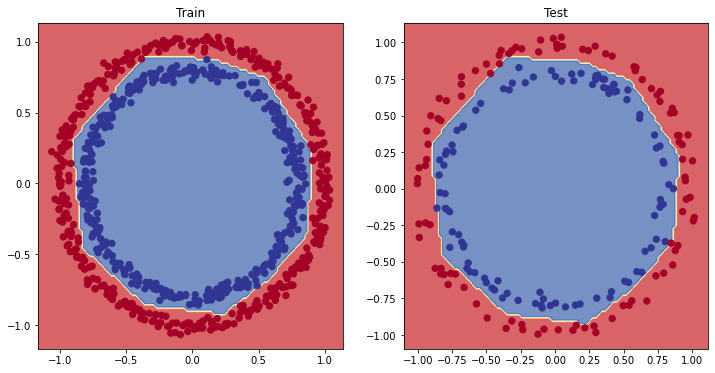

In [56]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)